## Same intial loading and cleaning steps ##

In [1]:
# Image Preparation Imports
import cv2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

file_name = '../data/wiki.mat'

def matlab_datenum_to_date(matlab_dn):
    return datetime.date.fromordinal(int(matlab_dn) - 366)

def compute_wiki_age(photo_year, birth_datenum):
    photo_date = datetime.date(photo_year, 7, 1)
    birth_date = matlab_datenum_to_date(birth_datenum)
    delta = photo_date - birth_date
    return delta.days / 365.2425


def process_matfile(file_name):
    # Load the data
    data = loadmat(file_name)['wiki'][0, 0]
    data_dict = {key: data[key] for key in data.dtype.names}

    # Convert data into filename-based dictionary
    filename_dict = {}

    for i in range(len(data_dict['full_path'][0])):
        # Remove invalid faces
        if np.isinf(data_dict['face_score'][0][i]) or not np.isnan(data_dict['second_face_score'][0][i]):
            continue

        filename = data_dict['full_path'][0][i][0]
        filename_dict[filename] = compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])

    return filename_dict

# Load filenames anda ssociated data
data = process_matfile(file_name)

In [2]:
#some data cleaning to get rid of excessively large or negative values in the predicted age category
print(len(data))
mean_val = sum(data.values()) / len(data)
print(mean_val)
for key in list(data.keys()):
    if data[key] > 100 or data[key] < 1:
        del data[key]
print(len(data))
print(min(data.values()), max(data.values()))

40216
38.60996556567274
40147
1.3525260614523227 99.87337180092678


In [3]:
# Load in images
images = []
for i in data.keys():  
    img = cv2.imread('../data/wiki_crop/'+i)
    images.append(img)

print(f"Number of images loaded: {len(images)}")

Number of images loaded: 40147


In [4]:
#resize all images 
new_images = []
width = 200
height = 200
for image in images:
    new_im = cv2.resize(image, (width,height), interpolation=cv2.INTER_LINEAR)
    new_images.append(new_im)

## new way to classify ages into bins of 5 years ##

In [5]:
edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['0-5 years', '5-10 years', '10-15 years', '15-20 years',
              '20-25 years', '25-30 years', '30-35 years', '35-40 years',
             '40-45 years', '45-50 years', '50-55 years', '55-60 years',
              '60-65 years', '65-70 years', '70-75 years', '75-80 years', 
             '80-85 years', '85-90 years', '90-95 years', '95-100 years']

def classify_age(age, edges, labels):
    for i in range(len(edges) - 1):
        if edges[i] <= age < edges[i + 1]:
            return labels[i]
    return None  

classification = [classify_age(data[key], edges, labels) for key in data.keys()]

In [6]:
# split in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(new_images, classification, test_size = 0.2, random_state = 1)

In [7]:
label_to_int_mapping = {label: idx for idx, label in enumerate(labels)}

# Function to map labels to integers
def label_to_int(label):
    return label_to_int_mapping[label]

# Convert datasets
X_train = np.array(x_train, dtype='float32')
X_test = np.array(x_test, dtype='float32')

# Map labels to integers
y_train_int = np.array([label_to_int(lbl) for lbl in y_train], dtype='int32')
y_test_int = np.array([label_to_int(lbl) for lbl in y_test], dtype='int32')

# Normalize pixel values to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_int.shape)

X_train shape: (32117, 200, 200, 3)
y_train shape: (32117,)


In [8]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax')  #the 20 different categories for age 
])

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model2.fit(
    X_train, y_train_int,
    validation_split=0.1,  # 10% of training as validation
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
904/904 [==============================] - 810s 890ms/step - loss: 2.3788 - accuracy: 0.1814 - val_loss: 2.3062 - val_accuracy: 0.1943
Epoch 2/5
904/904 [==============================] - 786s 869ms/step - loss: 2.1984 - accuracy: 0.2286 - val_loss: 2.2658 - val_accuracy: 0.1986
Epoch 3/5
904/904 [==============================] - 2850s 3s/step - loss: 1.9383 - accuracy: 0.3224 - val_loss: 2.3736 - val_accuracy: 0.1986
Epoch 4/5
904/904 [==============================] - 792s 876ms/step - loss: 1.3580 - accuracy: 0.5324 - val_loss: 2.9499 - val_accuracy: 0.1824
Epoch 5/5
904/904 [==============================] - 6139s 7s/step - loss: 0.6576 - accuracy: 0.7801 - val_loss: 4.4335 - val_accuracy: 0.1803


In [10]:
test_loss, test_acc = model2.evaluate(X_test, y_test_int, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

predictions = model2.predict(X_test[:5])
pred_classes = np.argmax(predictions, axis=1)

int_to_label = {v: k for k, v in label_to_int_mapping.items()}

print("\nSample Predictions:")
for i in range(5):
    predicted_label = int_to_label[pred_classes[i]]
    actual_label = int_to_label[y_test_int[i]]
    print(f"Predicted: {predicted_label}, Actual: {actual_label}")

251/251 [==============================] - 30s 119ms/step - loss: 4.4633 - accuracy: 0.1875
Test Loss: 4.4633, Test Accuracy: 0.1875
1/1 [==============================] - 2s 2s/step

Sample Predictions:
Predicted: 20-25 years, Actual: 25-30 years
Predicted: 25-30 years, Actual: 20-25 years
Predicted: 25-30 years, Actual: 35-40 years
Predicted: 30-35 years, Actual: 20-25 years
Predicted: 30-35 years, Actual: 20-25 years


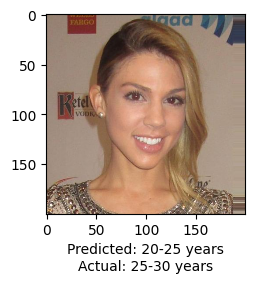

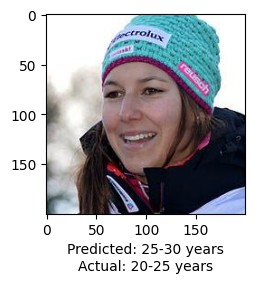

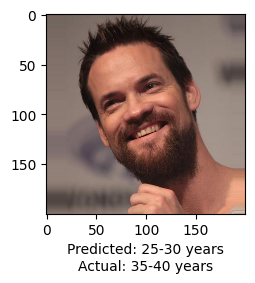

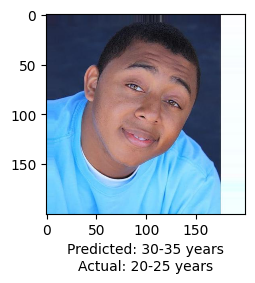

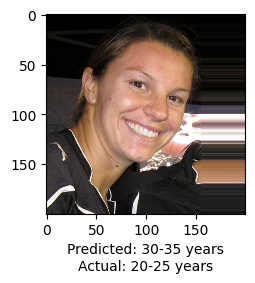

In [11]:
for i in range(5):
    predicted_label = int_to_label[pred_classes[i]]
    actual_label = int_to_label[y_test_int[i]]

    plt.figure(figsize=[15,15])
    plt.subplot(5,1, i+1);plt.imshow(X_test[i][:,:,::-1])
    plt.xlabel(f"Predicted: {predicted_label}\nActual: {actual_label}")


In [13]:
# Get predictions
all_predictions = model2.predict(X_test)
all_pred_classes = np.argmax(all_predictions, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_int, all_pred_classes)
precision = precision_score(y_test_int, all_pred_classes, average='weighted') 
recall = recall_score(y_test_int, all_pred_classes, average='weighted')        
f1 = f1_score(y_test_int, all_pred_classes, average='weighted')                

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


251/251 [==============================] - 22s 89ms/step
Accuracy: 0.1875
Precision: 0.1683
Recall: 0.1875
F1 Score: 0.1709


C:\Users\liper\anaconda3\envs\TF\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## New attempt ##

In [14]:
classification = [int(data[key]) for key in data.keys()]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(new_images, classification, test_size = 0.2, random_state = 1)

In [16]:

y_train = np.array(y_train, dtype='float32') 
y_test  = np.array(y_test, dtype='float32')

X_train /= 255.0
X_test /= 255.0

In [17]:
model2_2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')  #the 100 different ages 
])

model2_2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model2_2.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training as validation
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
904/904 [==============================] - 349s 382ms/step - loss: 4.0833 - accuracy: 0.0387 - val_loss: 4.0703 - val_accuracy: 0.0367
Epoch 2/5
904/904 [==============================] - 788s 872ms/step - loss: 4.0544 - accuracy: 0.0386 - val_loss: 4.0536 - val_accuracy: 0.0470
Epoch 3/5
904/904 [==============================] - 797s 882ms/step - loss: 4.0531 - accuracy: 0.0407 - val_loss: 4.0766 - val_accuracy: 0.0370
Epoch 4/5
904/904 [==============================] - 791s 875ms/step - loss: 4.0497 - accuracy: 0.0393 - val_loss: 4.0626 - val_accuracy: 0.0392
Epoch 5/5
904/904 [==============================] - 819s 906ms/step - loss: 4.0476 - accuracy: 0.0399 - val_loss: 4.0530 - val_accuracy: 0.0392


In [19]:
# Evaluate the model (loss will still be calculated as usual)
test_loss, _ = model2_2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
predictions = model2_2.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)  # Predicted classes

# Custom accuracy calculation (within 5 years)
within_5_years = np.abs(pred_classes - y_test) <= 5
custom_accuracy = np.mean(within_5_years)  # Fraction of correct predictions

print(f"Custom Accuracy (within 5 years): {custom_accuracy:.4f}")

# Sample predictions
print("\nSample Predictions:")
for i in range(5):
    print(f"Predicted: {pred_classes[i]}, Actual: {y_test[i]}, "
          f"Within 5 years: {'Yes' if within_5_years[i] else 'No'}")

251/251 [==============================] - 49s 193ms/step - loss: 4.0284 - accuracy: 0.0437
Test Loss: 4.0284
251/251 [==============================] - 46s 181ms/step
Custom Accuracy (within 5 years): 0.3910

Sample Predictions:
Predicted: 26, Actual: 25.0, Within 5 years: Yes
Predicted: 26, Actual: 22.0, Within 5 years: Yes
Predicted: 26, Actual: 37.0, Within 5 years: No
Predicted: 26, Actual: 20.0, Within 5 years: No
Predicted: 26, Actual: 22.0, Within 5 years: Yes


In [20]:
# Get predictions
all_predictions = model2_2.predict(X_test)
all_pred_classes = np.argmax(all_predictions, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, all_pred_classes)
precision = precision_score(y_test, all_pred_classes, average='weighted')  
recall = recall_score(y_test, all_pred_classes, average='weighted')        
f1 = f1_score(y_test, all_pred_classes, average='weighted')                

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

251/251 [==============================] - 46s 181ms/step
Accuracy: 0.0437
Precision: 0.0019
Recall: 0.0437
F1 Score: 0.0037


C:\Users\liper\anaconda3\envs\TF\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
